# Customer churn - Bank

## import and settings

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

**Plotty setting**

In [2]:
# Set Plotly as Pandas plotting backend

pd.options.plotting.backend = "plotly"
np.set_printoptions(precision=2, suppress=True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format

## Data collection

In [4]:

# Download latest version
path = kagglehub.dataset_download("gauravtopre/bank-customer-churn-dataset")

print("Path to dataset files:", path)

file_path = os.path.join(path, "Bank Customer Churn Prediction.csv")

# קריאה ל-DataFrame
df = pd.read_csv(file_path)





Path to dataset files: /kaggle/input/bank-customer-churn-dataset


In [5]:

# הצגת מידע ראשוני
print(df.head())
print(df.info())
print(df.describe(include="all"))

   customer_id  credit_score country  gender  age  tenure   balance  \
0     15634602           619  France  Female   42       2      0.00   
1     15647311           608   Spain  Female   41       1  83807.86   
2     15619304           502  France  Female   42       8 159660.80   
3     15701354           699  France  Female   39       1      0.00   
4     15737888           850   Spain  Female   43       2 125510.82   

   products_number  credit_card  active_member  estimated_salary  churn  
0                1            1              1         101348.88      1  
1                1            0              1         112542.58      0  
2                3            1              0         113931.57      1  
3                2            0              0          93826.63      0  
4                1            1              1          79084.10      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          

### **Missing values**

In [6]:
# בדיקה של חוסרים
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


### **Target values counter**


חלוקת target - Churn:
churn
0    7963
1    2037
Name: count, dtype: int64


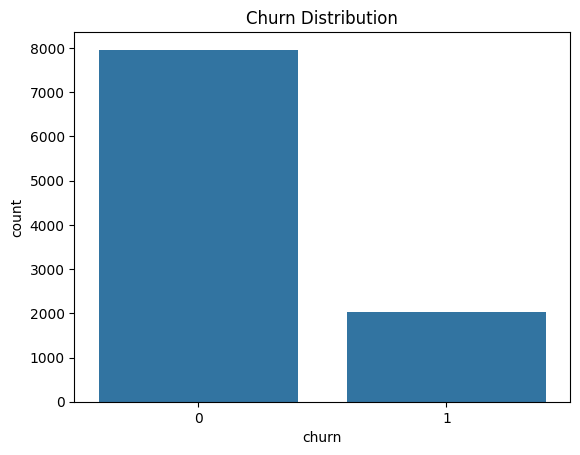

In [7]:
#  בדיקת חלוקת target 'Churn' ===
print("\nחלוקת target - Churn:")
print(df['churn'].value_counts())
# גרף חלוקת churn
sns.countplot(x='churn', data=df)
plt.title("Churn Distribution")
plt.show()

**Drop customerID - not relevant**

In [8]:

# זריקת customer_id
df = df.drop(columns=["customer_id"])

###**Print distributions**

In [10]:


# --- שלב 2: הגדרת target ופיצ’רים ---
target = "churn"
X = df.drop(columns=[target])
y = df[target]

# --- שלב 3: חלוקה לעמודות מספריות וקטגוריות ---
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
Categorical: ['country', 'gender']


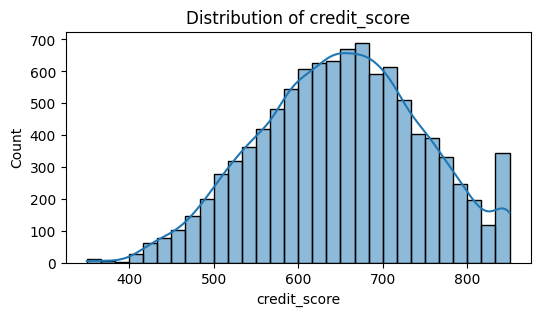

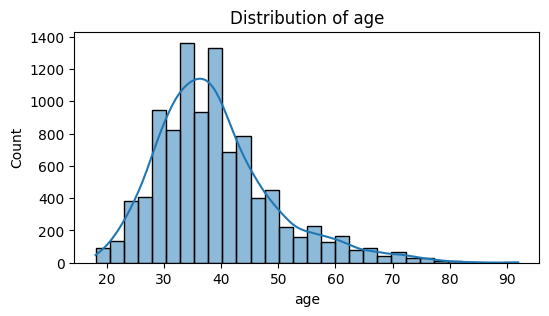

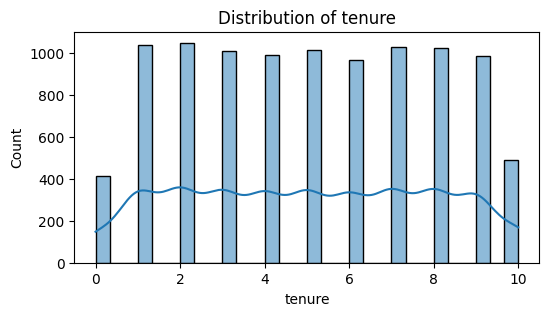

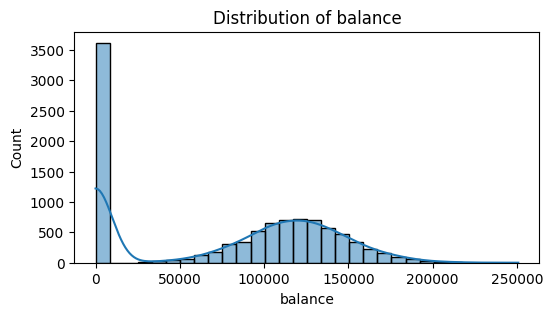

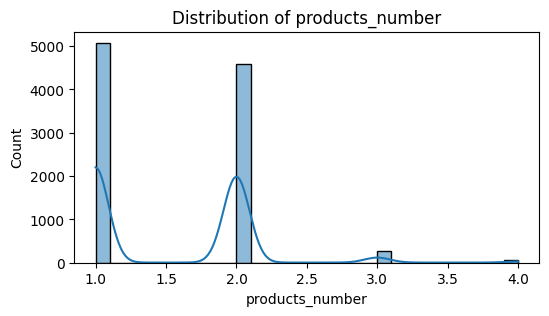

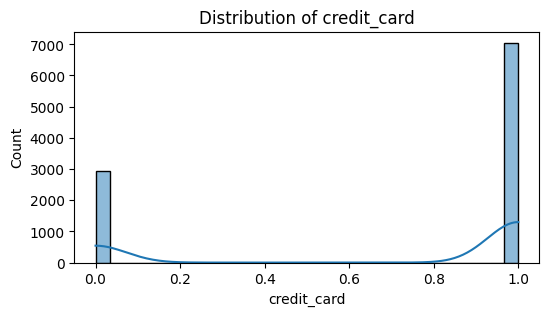

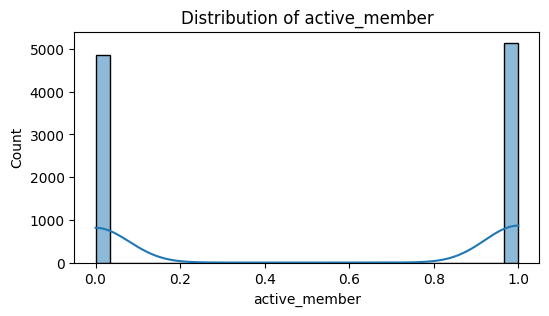

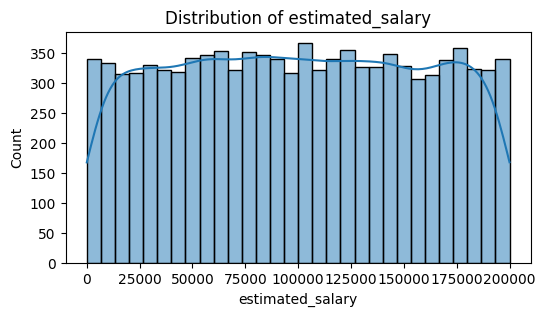

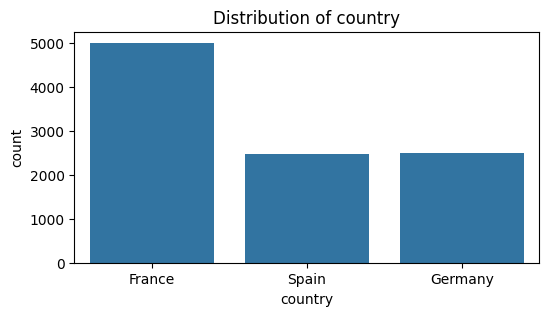

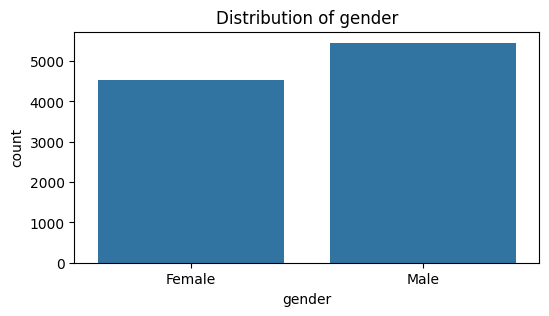

In [11]:
# גרפים בסיסיים על פיצ'רים מספריים
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# גרפים בסיסיים על פיצ'רים קטגוריאליים
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.show()

### **Correlation between Numberical features**

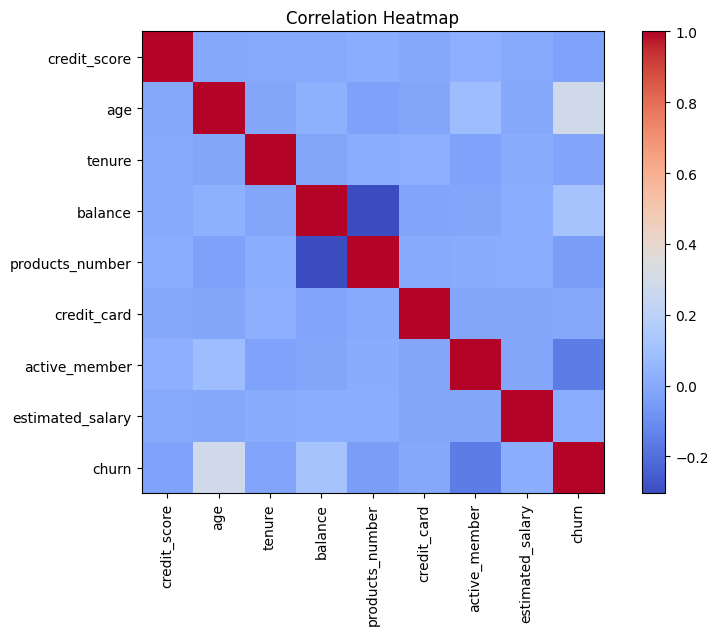

In [12]:


# קורלציה בין פיצ'רים מספריים
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Heatmap")
plt.show()


## Preproccesing

In [21]:

# --- שלב 4: בניית טרנספורמציות ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# --- שלב 5: חיבור הכל ל-ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)


### **Imbalance Taking care 1:2**

In [22]:
from sklearn.utils import resample

# נפריד את המחלקות
df_majority = df[df['churn'] == 0]
df_minority = df[df['churn'] == 1]

print("לפני איזון:")
print(df['churn'].value_counts())

# נגדיל את minority כדי להגיע ליחס ~1:2
df_minority_upsampled = resample(
    df_minority,
    replace=True,  # דגימה עם החזרה
    n_samples=int(len(df_majority) / 2),  # minority = חצי מגודל majority
    random_state=42
)

# נאחד חזרה
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# נערבב
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nאחרי איזון:")
print(df_balanced['churn'].value_counts())


לפני איזון:
churn
0    7963
1    2037
Name: count, dtype: int64

אחרי איזון:
churn
0    7963
1    3981
Name: count, dtype: int64


In [23]:
df_balanced

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,805,Germany,Female,26,8,42712.87,2,1,1,28861.69,0
1,712,France,Female,27,2,133009.51,1,1,0,126809.15,0
2,489,Germany,Female,52,1,131441.51,1,1,0,37240.11,1
3,778,Spain,Female,47,6,127299.34,2,1,0,124694.99,0
4,716,France,Female,44,3,109528.28,1,1,0,27341.63,1
...,...,...,...,...,...,...,...,...,...,...,...
11939,568,Germany,Male,46,8,150836.92,1,0,0,64516.80,1
11940,683,France,Male,38,7,109346.13,2,1,0,102665.92,0
11941,606,Spain,Male,34,3,161572.24,1,0,1,191076.22,0
11942,678,France,Female,32,5,0.00,2,1,0,90284.47,0


### **Split data to train / test**


In [24]:
from sklearn.model_selection import train_test_split

# === 1. הפרדת X ו-y ===
X = df_balanced.drop(columns=['churn'])
y = df_balanced['churn']
# === 5. Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## **Train model**

In [25]:
from xgboost import XGBClassifier

# --- המרת X_train/X_test לאחר preprocessing ---
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

# --- מודל XGB עם weight imbalance ---
# XGBClassifier רגיל
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.6,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42
)

# אימון עם early stopping
xgb_model.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_test_proc, y_test)],
    verbose=True
)




[0]	validation_0-logloss:0.68893	validation_1-logloss:0.68944
[1]	validation_0-logloss:0.68471	validation_1-logloss:0.68553
[2]	validation_0-logloss:0.68034	validation_1-logloss:0.68153
[3]	validation_0-logloss:0.67874	validation_1-logloss:0.68024
[4]	validation_0-logloss:0.67449	validation_1-logloss:0.67649
[5]	validation_0-logloss:0.67272	validation_1-logloss:0.67505
[6]	validation_0-logloss:0.67024	validation_1-logloss:0.67276


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning:

[10:25:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




[7]	validation_0-logloss:0.66722	validation_1-logloss:0.67005
[8]	validation_0-logloss:0.66471	validation_1-logloss:0.66771
[9]	validation_0-logloss:0.66248	validation_1-logloss:0.66563
[10]	validation_0-logloss:0.66014	validation_1-logloss:0.66363
[11]	validation_0-logloss:0.65735	validation_1-logloss:0.66120
[12]	validation_0-logloss:0.65584	validation_1-logloss:0.66004
[13]	validation_0-logloss:0.65300	validation_1-logloss:0.65762
[14]	validation_0-logloss:0.65078	validation_1-logloss:0.65554
[15]	validation_0-logloss:0.64771	validation_1-logloss:0.65300
[16]	validation_0-logloss:0.64486	validation_1-logloss:0.65049
[17]	validation_0-logloss:0.64122	validation_1-logloss:0.64719
[18]	validation_0-logloss:0.63837	validation_1-logloss:0.64473
[19]	validation_0-logloss:0.63560	validation_1-logloss:0.64223
[20]	validation_0-logloss:0.63408	validation_1-logloss:0.64104
[21]	validation_0-logloss:0.63128	validation_1-logloss:0.63859
[22]	validation_0-logloss:0.62836	validation_1-logloss:0.6

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, ...)

## Evaluation

In [26]:
# --- חיזוי והערכה ---
y_pred = xgb_model.predict(X_test_proc)
print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1593
           1       0.80      0.87      0.83       796

    accuracy                           0.88      2389
   macro avg       0.87      0.88      0.87      2389
weighted avg       0.89      0.88      0.89      2389



## LogLoss train vs Test

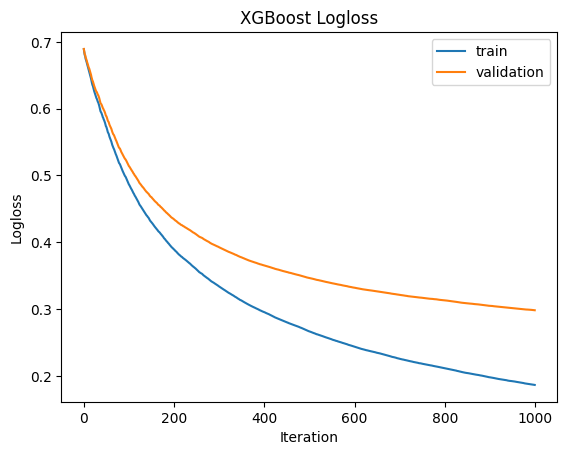

In [27]:
# --- גרף logloss ---
results = xgb_model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='validation')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss')
plt.legend()
plt.show()